In [1]:
import os
import matplotlib.pyplot as plt
import nibabel as nib
from glob import glob
from PIL import Image
from tqdm import tqdm_notebook as tqdm

plt.set_cmap('gray')
plt.rcParams['figure.figsize'] = (12, 10)

import numpy as np
from scipy.ndimage.morphology import binary_erosion, binary_fill_holes

def get_viz_vol(case_path, kw):
    png_files = sorted([f for f in glob('{}/*_{}.png'.format(case_path, kw))])
    vol = np.array([np.array(Image.open(fp)) for fp in png_files])
    vol = vol[..., 0]
    vol = vol / vol.mean()
    vol = np.interp(vol, (vol.min(), vol.max()), (0, 1))
    vol = np.rot90(vol, axes=(1, 2), k=2)
    return vol

<Figure size 432x288 with 0 Axes>

In [ ]:
data = nib.load(
    '/mnt/datasets/srivathsa/jiang_raid/projects/SubtleGAN/data/IXI/IXI_MRA/coreg/\
IXI002-Guys-0828/IXI002-Guys-0828-MRA.nii.gz').get_fdata()
data = data.transpose(2, 0, 1)
data = np.rot90(data, axes=(1, 2))
data = data / data.mean()

In [ ]:
th = np.percentile(data, 99.8)
data_th = data >= th

plt.imshow(data[30])

In [ ]:
plt.imshow(data_th[35])

In [ ]:
mip_ax = np.max(data, axis=0)
mip_cor = np.max(data, axis=1)
mip_sag = np.max(data, axis=2)

In [ ]:
plt.imshow(mip_ax)

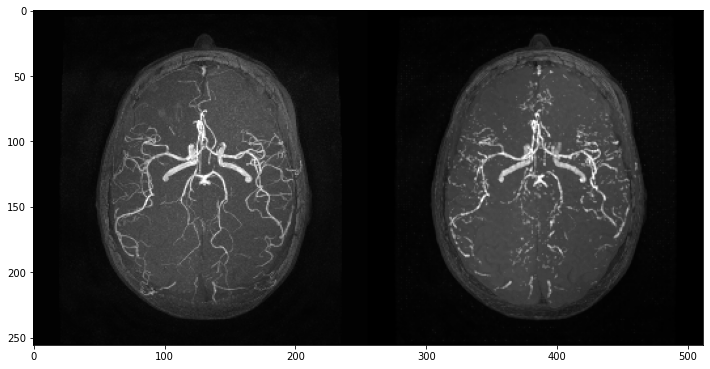

In [5]:
plot_base = '/home/srivathsa/projects/SubtleGad/train/prototypes/mmt/MMTUNetHybrid/model/'
plot_base += 'IXI_MRA_Synth_epo200_bs12_lrg0.0005_5.0_20.0_0.0_0.1_vgg0/viz/val/01'

cnum = 'IXI051-HH-1328'

case_dir = os.path.join(plot_base, cnum)

ip_vol = get_viz_vol(case_dir, 'input')
gt_vol = get_viz_vol(case_dir, 'gt')
op_vol = get_viz_vol(case_dir, 'output')

gt_mip = np.max(gt_vol, axis=0)
op_mip = np.max(op_vol, axis=0)

plt.imshow(np.hstack([gt_mip, op_mip]))

In [ ]:
sl = 50
plt.imshow(ip_vol[sl])

In [ ]:
plt.imshow(np.hstack([gt_vol[sl], op_vol[sl]]))

### Tensorboard Image Callback

In [ ]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import PIL.Image as Image
import io
from glob import glob
import numpy as np

def byte_to_array(img_bstr):
    return np.array(Image.open(io.BytesIO(img_bstr)))

def get_img_from_tag(ev_ac, tag):
    imgs = ev_ac.Images(tag)
    
    img_array = []
    for idx, img in enumerate(imgs):
        img_bstr = img.encoded_image_string
        img_el = img_array.append(byte_to_array(img_bstr))
        
    img_array = np.array(img_array)
    img_array = img_array[0, ..., 0]
    img_array = np.rot90(img_array, k=2)
    return img_array

log_path = '/home/srivathsa/projects/SubtleGad/train/prototypes/mmt/MMTUNetHybrid/model/\
IXI_MRA_Synth_epo200_bs12_lrg0.0005_5.0_20.0_0.0_0.1_vgg0/log'

num_files = len(glob('{}/*'.format(log_path)))

tf_size_guidance = {
    'compressedHistograms': 0,
    'images': 1,
    'scalars': 0,
    'histograms': 0
}

# event_acc = EventAccumulator(log_path, size_guidance=tf_size_guidance)
# event_acc.Reload()

fps = sorted([f for f in glob('{}/*'.format(log_path))])

img_disps = []

for fp in tqdm(fps, total=len(fps)):
    event_acc = EventAccumulator(fp)
    event_acc.Reload()
    
    ip = get_img_from_tag(event_acc, 'train/inputs')
    ip2, ip1 = ip.reshape(256, -1, 256).transpose(1, 0, 2)
    gt = get_img_from_tag(event_acc, 'train/targets')
    op = get_img_from_tag(event_acc, 'train/outputs')
    
    row1 = np.hstack([ip1, ip2])
    row2 = np.hstack([gt, op])
    img_disp = np.vstack([row1, row2])
    img_disps.append(img_disp)

In [ ]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

@interact
def show_tb_imgs(idx=(0, len(img_disps)-1, 1)):
    plt.imshow(img_disps[idx])
    plt.title('Index {}'.format(idx))
    plt.axis('off')

In [ ]:
def get_img_from_tag2(ev_ac, tag):
    imgs = ev_ac.Images(tag)
    
    img_array = []
    for idx, img in enumerate(imgs):
        img_bstr = img.encoded_image_string
        img_el = img_array.append(byte_to_array(img_bstr))
        
    img_array = np.array(img_array)
    img_array = img_array[2, ..., 0]
    img_array = np.rot90(img_array, k=2)
    return img_array

In [ ]:
ev_ac = EventAccumulator(fps[56])
ev_ac.Reload()

ip = get_img_from_tag2(ev_ac, 'train/inputs')
ip2, ip1 = ip.reshape(256, -1, 256).transpose(1, 0, 2)
gt = get_img_from_tag2(ev_ac, 'train/targets')
op = get_img_from_tag2(ev_ac, 'train/outputs')

In [ ]:
plt.imshow(np.hstack([gt, op]))